# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Data Science: 

## Final Project Group 11: Predicting the Midterm Election


**Harvard University**<br/>
**Fall 2019**<br/>
**Students**: Justin Bassey, Jake Boll, Chirstopher Lewis, Sebastian Schwartz

<hr style="height:2pt">

### Exploratory Data Analysis

- What data are we dealing with?
- How have we explored the data (initial explorations, data cleaning and reconciliation, etc)? 
- Visualizations and captions that summarize the noteworthy findings of the EDA.
- A revised project question based on the insights you gained through EDA (specific to data).
- A baseline model.

### Project Goal 
The primary goal of this project is to explain the outcomes of the 2018 midterm
elections in the House. Any piece of information from before election day can be used to perform
this analysis, but the suggested feature set should include past elections, polling data, and demographic information of congressional districts

In [378]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import requests
from bs4 import BeautifulSoup

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## House District Candidate Data

In [333]:
# import house data
house_district_data = pd.read_csv('data/1976_2018_house.csv')
# add winners column
house_district_data['winner'] = 0
# drop unecessary columns
to_drop = ['state_fips', 'state_cen', 'state_ic', 'office', 'stage', 'runoff', 'special', 'mode', 'unofficial', 
           'version']
house_district_data.drop(to_drop, inplace=True, axis=1)

#clean data types
house_district_data['candidatevotes'] = house_district_data['candidatevotes'].str.replace(',','')
house_district_data['candidatevotes'] = house_district_data['candidatevotes'].apply(pd.to_numeric)
# rename state po to abr
house_district_data.rename(columns={"state_po": "state_abr"}, inplace=True)

house_district_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29636 entries, 0 to 29635
Data columns (total 10 columns):
year              29636 non-null int64
state             29636 non-null object
state_abr         29636 non-null object
district          29636 non-null int64
candidate         27516 non-null object
party             26214 non-null object
writein           29636 non-null bool
candidatevotes    29636 non-null int64
totalvotes        29636 non-null float64
winner            29636 non-null int64
dtypes: bool(1), float64(1), int64(4), object(4)
memory usage: 2.1+ MB


In [251]:
# values for districts, years, and states
district_nums = house_district_data.district.unique()
district_years = house_district_data.year.unique()
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',
          'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland',
          'Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada',
          'New_Hampshire','New_Jersey','New_Mexico','New_York','North_Carolina','North_Dakota','Ohio','Oklahoma',
          'Oregon','Pennsylvania','Rhode_Island','South_Carolina','South_Dakota','Tennessee','Texas','Utah','Vermont',
          'Virginia','Washington','West_Virginia','Wisconsin','Wyoming']

In [252]:
# update winners data column
# THIS FUNCTION TAKES A WHILE
for state in states:
    for year in house_district_data.year.unique():
        for district in house_district_data.district.unique():
            try:
                index = house_district_data['candidatevotes'].loc[(house_district_data['state'] == state) &
                                                                  (house_district_data['year'] == year) &
                                                                  (house_district_data['district'] == district)].idxmax
                house_district_data.at[index, 'winner'] = 1
            except:
                pass

house_district_data.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner
0,1976,Alabama,AL,1,Bill Davenport,democrat,False,58906,157170.0,0
1,1976,Alabama,AL,1,Jack Edwards,republican,False,98257,157170.0,1
2,1976,Alabama,AL,1,NaN,NaN,True,7,157170.0,0
3,1976,Alabama,AL,2,J. Carole Keahey,democrat,False,66288,156362.0,0
4,1976,Alabama,AL,2,NaN,NaN,True,5,156362.0,0
5,1976,Alabama,AL,2,"William L. """"Bill"""" Dickinson",republican,False,90069,156362.0,1
6,1976,Alabama,AL,3,Bill Nichols,democrat,False,106935,108048.0,1
7,1976,Alabama,AL,3,NaN,NaN,True,2,108048.0,0
8,1976,Alabama,AL,3,Ogburn Gardner,prohibition,False,1111,108048.0,0
9,1976,Alabama,AL,4,Tom Bevill,democrat,False,141490,176022.0,1


In [256]:
# Find nas
house_district_data.isna().sum()

# drop rows with no candidate
house_district_data = house_district_data.dropna(subset=['candidate'])
# fill party
house_district_data['party'] = house_district_data['party'].fillna('Unknown')

display(house_district_data.isna().sum())

year              0
state             0
state_abr         0
district          0
candidate         0
party             0
writein           0
candidatevotes    0
totalvotes        0
winner            0
dtype: int64

### EDA

**How do states traditionally vote?**

In [366]:
dems = house_district_data.loc[house_district_data['party'] == 'democrat']
gops = house_district_data.loc[house_district_data['party'] == 'republican']


democry = dems.groupby(['state']).agg(({
    'candidatevotes': np.mean
}))

gopcry = gops.groupby(['state']).agg(({
    'candidatevotes': np.mean
}))

democratic = democry-gopcry
democratic['positive'] = democratic['candidatevotes'] > 0

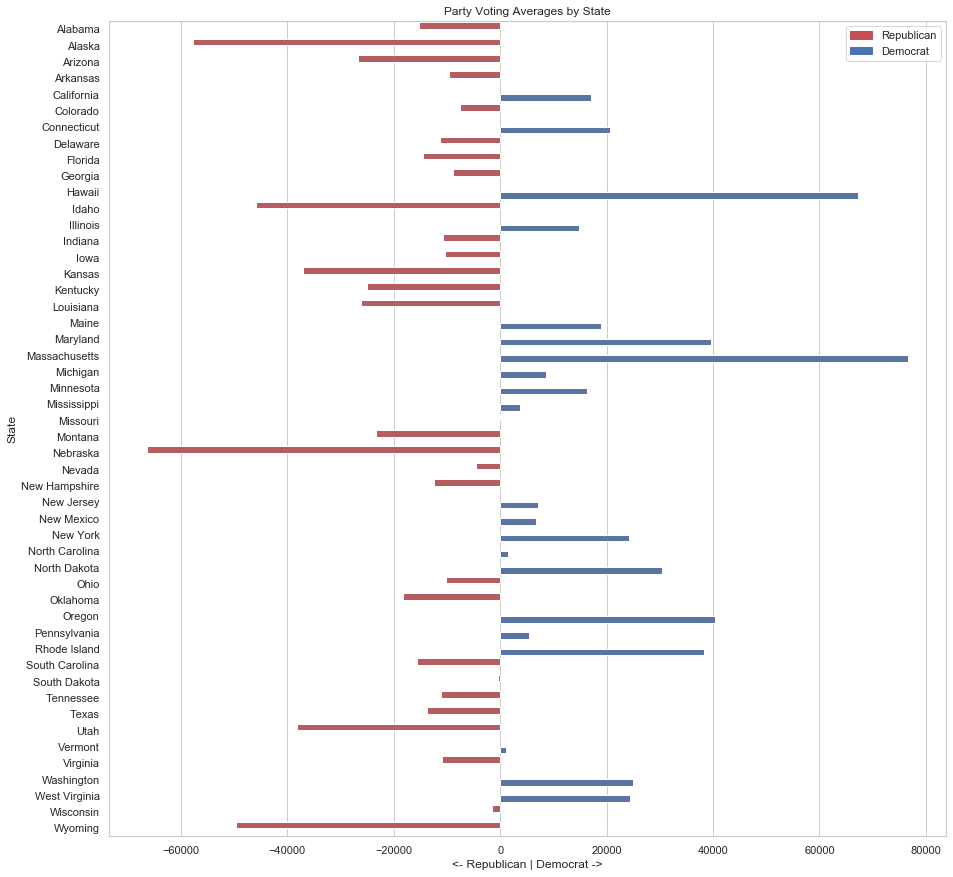

In [391]:
# show average vote
fig, ax = plt.subplots(figsize=(15,15))

sns.barplot(x='candidatevotes', y=democratic.index, data=democratic, hue='positive', palette=['r', 'b'])

ax.set(xlabel='<- Republican | Democrat ->', ylabel='State', title='Party Voting Averages by State')
# legend
red_patch = mpatches.Patch(color='r', label='Republican')
blue_patch = mpatches.Patch(color='b', label='Democrat')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()

## House Seat Changes by President

In [392]:
house_seat_change = requests.get("https://www.presidency.ucsb.edu/statistics/data/seats-congress-gainedlost-the-presidents-party-mid-term-elections")

In [393]:
seats_soup = BeautifulSoup(house_seat_change.content, 'html.parser') 

In [412]:
def get_year(tag):
    return tag.find_all('td')[0].text

def get_president(tag):
    return tag.find_all('td')[2].text

def get_pres_party(tag):
    return tag.find_all('td')[3].text
    
def get_party_seats_to_defend(tag):
    return tag.find_all('td')[10].text.strip()
    
def get_house_seat_change(tag):
    return tag.find_all('td')[12].text
    
def parse_presidents(seats_soup):
    preslist = []
    
    pres_soup = seats_soup.find('tbody').find_all('tr')
    for i in range(len(pres_soup)):
        pres_dict = {
            'year': get_year(pres_soup[i]),
            'president': get_president(pres_soup[i]),
            'party': get_pres_party(pres_soup[i]),
            'seats to defend': get_party_seats_to_defend(pres_soup[i]),
            'seat change': get_house_seat_change(pres_soup[i])
        }
        preslist.append(pres_dict)
    return preslist

# fix data types
seat_change_by_president = pd.DataFrame(parse_presidents(seats_soup))
seat_change_by_president[['seat change', 'seats to defend', 'year']] = seat_change_by_president[['seat change', 'seats to defend', 'year']].apply(pd.to_numeric)
# rename columns
seat_change_by_president.rename(columns={'party': 'president_party', 'president': 'sitting_president'}, inplace=True)
seat_change_by_president.head()


,president_party,sitting_president,seat change,seats to defend,year
0,D,Franklin D. Roosevelt,9,313,1934
1,D,Franklin D. Roosevelt,-81,334,1938
2,D,Franklin D. Roosevelt,-46,267,1942
3,D,Harry S. Truman,-45,244,1946
4,D,Harry S. Truman,-29,263,1950


## EDA

**Are there differences in House seats lost by Democratic vs Republican Presidents?**

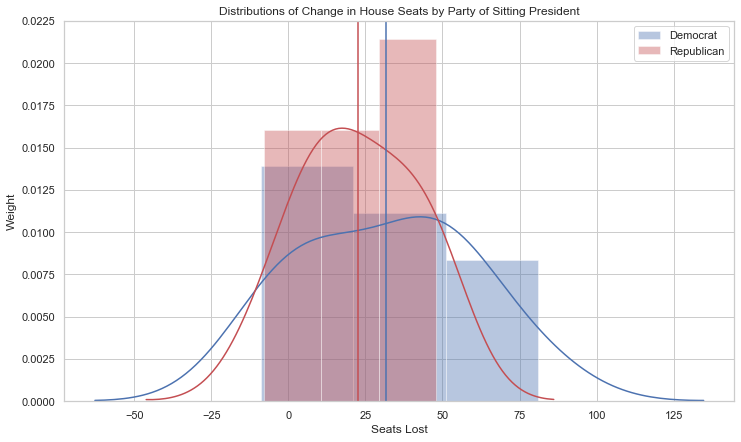

Average Democratic Seats Lost: 31.75
Average Republican Seats Lost: 22.7


In [411]:
dem_seat_change = -1 * seat_change_by_president['seat change'].loc[seat_change_by_president['president_party'] == 'D']
rep_seat_change = -1 * seat_change_by_president['seat change'].loc[seat_change_by_president['president_party'] == 'R']

fig, ax = plt.subplots(figsize=(12,7))

# plot seat change by party
sns.distplot(dem_seat_change, label='Democrat', color='b')
sns.distplot(rep_seat_change, label='Republican', color='r')

# plot average seat loss
plt.axvline(dem_seat_change.mean(), color='b')
plt.axvline(rep_seat_change.mean(), color='r')

ax.set(title='Distributions of Change in House Seats by Party of Sitting President', ylabel='Weight', xlabel='Seats Lost')

plt.legend(loc='best')
plt.show()

print('Average Democratic Seats Lost:', dem_seat_change.mean())
print('Average Republican Seats Lost:', rep_seat_change.mean())


We can see that Democrats tend to lose more seats than Republicans

In [330]:
# merge president data with house data
# lose half of rows, but we only care about midterm years, so we're dropping non-midterm elections
house_plus_president = pd.merge(house_district_data, seat_change_by_president, on='year')
house_plus_president.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner,president_party,sitting_president,seat change,seats to defend
0,1978,Alabama,AL,1,L. W. Noonan,democrat,False,40450,112161.0,0,D,Jimmy Carter,-15,292
1,1978,Alabama,AL,1,Jack Edwards,republican,False,71711,112161.0,1,D,Jimmy Carter,-15,292
2,1978,Alabama,AL,2,Wendell Mitchell,democrat,False,49341,107265.0,0,D,Jimmy Carter,-15,292
3,1978,Alabama,AL,2,"William L. """"Bill"""" Dickinson",republican,False,57924,107265.0,1,D,Jimmy Carter,-15,292
4,1978,Alabama,AL,3,Bill Nichols,democrat,False,74895,74897.0,1,D,Jimmy Carter,-15,292


## District Level Demographics

In [414]:
# load in data
district_demo = {}
for state in states:
    csv = (state + '_District_all.csv')
    district_demo[state] = pd.read_csv('data/state_districts/{}'.format(csv)).drop(['Topic', 'Subject'], axis=1).transpose()
    # clean data
    district_demo[state].columns = district_demo[state].iloc[0]
    district_demo[state] = district_demo[state].drop(['Title'])
    district_demo[state] = district_demo[state].dropna(axis='columns', how='all')
    # add district column
    district_demo[state]['district'] = 0
    dist_lens = range(1,len(district_demo[state].iloc[::2])+1)
    district_demo[state].iloc[::2]['district'] = dist_lens
    # add year column
    district_demo[state]['year_demo'] = 2018
    # add state name column
    district_demo[state]['state'] = state
    


/Users/justinbassey/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [415]:
# concat all state districts together
all_dist_demo = pd.concat(district_demo)
all_dist_demo = all_dist_demo.loc[::2].apply(pd.to_numeric, errors='ignore')

all_dist_demo.head()

Title                        Total population    Male  Female  Under 5 years  5 to 9 years  10 to 14 years  15 to 19 years  20 to 24 years  25 to 34 years  35 to 44 years  45 to 54 years  55 to 59 years  60 to 64 years  65 to 74 years  75 to 84 years  85 years and over  Median age (years)  18 years and over  65 years and over Total population  One race   White  Black or African American  American Indian and Alaska Native  Asian  Native Hawaiian and Other Pacific Islander  Some other race  Two or more races Total population  Hispanic or Latino (of any race)  Mexican  Puerto Rican  Cuban  Other Hispanic or Latino  Not Hispanic or Latino Total population  Native  Born in United States  State of residence  Different state  Born in Puerto Rico, U.S. Island areas, or born abroad to American parent(s)  Foreign born Total population American  Arab Czech Danish Dutch English French (except Basque)  ...  Health care and social assistance  Arts, entertainment, and recreation  Accommodation and food services  Other services (except public administration)  Industries not classified  Total for all sectors  Agriculture, forestry, fishing and hunting  Mining, quarrying, and oil and gas extraction  Utilities  Construction  Manufacturing  Wholesale trade  Retail trade  Transportation and warehousing  Information  Finance and insurance  Real estate and rental and leasing  Professional, scientific, and technical services  Management of companies and enterprises  \
Alabama District 01 Estimate           715346  344543  370803          40891         38836           52357           49123           42514           89384           85553           91122           51510           46973           75805           38651              12627                40.3             552917             127083           715346    702333  479949                     196891                               6992  10627                                         183             7691              13013           715346                             24141    11214          4962    397                      7568                  691205           715346  693956                 689039              484623           204416                                               4917                                    21390           715346    98884  3062  1088    391  2730   48432                  15366  ...                              31599                                 3002                            30602                                          12278                         35                9449314                                       42350                                          35353     137961        755763        1775808           503659        971871                          424709       221649                 556464                              180089                                            748183                                   291736   
        District 02 Estimate           678122  326346  351776          42217         39603           44011           43990           46469           89934           81055           86722           45788           42971           67493           35146              12723                38.8             524810             115362           678122    663115  426674                     217977                               2838   7442                                          26             8158              15007           678122                             24953    13679          5686   1095                      4493                  653169           678122  659525                 651408              469032           182376                                               8117                                    18597           678122   145289  1279   550    380  3739   41455                   6629  ...                              36596                                 3086                            25154                                          10776    

## Merging Datasets

In [416]:
# merge president data with house data
# lose half of rows, but we only care about midterm years, so we're dropping non-midterm elections
house_plus_president = pd.merge(house_district_data, seat_change_by_president, on='year')
house_plus_president.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner,president_party,sitting_president,seat change,seats to defend
0,1978,Alabama,AL,1,L. W. Noonan,democrat,False,40450,112161.0,0,D,Jimmy Carter,-15,292
1,1978,Alabama,AL,1,Jack Edwards,republican,False,71711,112161.0,0,D,Jimmy Carter,-15,292
2,1978,Alabama,AL,2,Wendell Mitchell,democrat,False,49341,107265.0,0,D,Jimmy Carter,-15,292
3,1978,Alabama,AL,2,"William L. """"Bill"""" Dickinson",republican,False,57924,107265.0,0,D,Jimmy Carter,-15,292
4,1978,Alabama,AL,3,NaN,NaN,True,2,74897.0,0,D,Jimmy Carter,-15,292


In [419]:
# Final data (demographics are repeated from 2018)
data_all = pd.merge(house_plus_president, all_dist_demo, on=['state', 'district']) # note only had demographics in 2018
data_all.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner,president_party,sitting_president,seat change,seats to defend,Total population,Male,Female,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),18 years and over,65 years and over,Total population,One race,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Total population,Hispanic or Latino (of any race),Mexican,Puerto Rican,Cuban,Other Hispanic or Latino,Not Hispanic or Latino,Total population,...,Administrative and support and waste management and remediation services,Educational services,Health care and social assistance,"Arts, entertainment, and recreation",Accommodation and food services,Other services (except public administration),Industries not classified,Total for all sectors,"Agriculture, forestry, fishing and hunting","Mining, quarrying, and oil and gas extraction",Utilities,Construction,Manufacturing,Wholesale trade,Retail trade,Transportation and warehousing,Information,Finance and insurance,Real estate and rental and leasing,"Professional, scientific, and technical services",Management of companies and enterprises,Administrative and support and waste management and remediation services,Educational services,Health care and social assistance,"Arts, entertainment, and recreation",Accommodation and food services,Other services (except public administration),Industries not classified,Total for all sectors,"Agriculture, forestry, fishing and hunting","Mining, quarrying, and oil and gas extraction",Utilities,Construction,Manufacturing,Wholesale trade,Retail trade,Transportation and warehousing,Information,Finance and insurance,Real estate and rental and leasing,"Professional, scientific, and technical services",Management of companies and enterprises,Administrative and support and waste management and remediation services,Educational services,Health care and social assistance,"Arts, entertainment, and recreation",Accommodation and food services,Other services (except public administration),Industries not classified,year_demo
0,1978,Alabama,AL,1,L. W. Noonan,democrat,False,40450,112161.0,0,D,Jimmy Carter,-15,292,715346,344543,370803,40891,38836,52357,49123,42514,89384,85553,91122,51510,46973,75805,38651,12627,40.3,552917,127083,715346,702333,479949,196891,6992,10627,183,7691,13013,715346,24141,11214,4962,397,7568,691205,715346,...,16026,5276,31599,3002,30602,12278,35,9449314,42350,35353,137961,755763,1775808,503659,971871,424709,221649,556464,180089,748183,291736,476101,147262,1354120,47836,486923,290987,490,15611,135,38,58,1271,551,843,2864,511,258,1172,846,1420,111,749,144,1427,198,1331,1663,21,2018
1,1978,Alabama,AL,1,Jack Edwards,republican,False,71711,112161.0,0,D,Jimmy Carter,-15,292,715346,344543,370803,40891,38836,52357,49123,42514,89384,85553,91122,51510,46973,75805,38651,12627,40.3,552917,127083,715346,702333,479949,196891,6992,10627,183,7691,13013,715346,24141,11214,4962,397,7568,691205,715346,...,16026,5276,31599,3002,30602,12278,35,9449314,42350,35353,137961,755763,1775808,503659,971871,424709,221649,556464,180089,748183,291736,476101,147262,1354120,47836,486923,290987,490,15611,135,38,58,1271,551,843,2864,511,258,1172,846,1420,111,749,144,1427,198,1331,1663,21,2018
2,1982,Alabama,AL,1,William (Bill) Springer,libertarian,False,1812,144028.0,0,R,Ronald Reagan,-26,192,715346,344543,370803,40891,38836,52357,49123,42514,89384,85553,91122,51510,46973,75805,38651,12627,40.3,552917,127083,715346,702333,479949,196891,6992,10627,183,7691,13013,715346,24141,11214,4962,397,7568,691205,715346,...,16026,5276,31599,3002,30602,12278,35,9449314,42350,35353,137961,755763,1775808,503659,971871,424709,221649,556464,180089,748183,291736,476101,147262,1354120,47836,486923,290987,490,1561

In [420]:
X_train, X_test, y_train, y_test =train_test_split(data_all.loc[:, data_all.columns != 'winner'], 
                                                         data_all.winner, test_size=0.2, 
                                                         stratify = data_all.state)

# FiveThirtyEight Prediction Data

**Not sure if using this data is cheating, but here's FiveThirtyEights Predictions for House 2018**

In [238]:
fte_predictions = pd.read_csv('data/house_district_forecast.csv')
fte_predictions = fte_predictions[fte_predictions.model == 'classic']
fte_predictions = fte_predictions.drop(['special'], axis=1)
fte_predictions.head()

,forecastdate,state,district,candidate,party,incumbent,model,win_probability,voteshare,p10_voteshare,p90_voteshare
0,2018-08-01,AK,1,Don Young,R,True,classic,0.7185,49.35,43.04,55.59
1,2018-08-01,AK,1,Alyse S. Galvin,D,False,classic,0.2815,44.11,37.77,50.39
2,2018-08-01,AK,1,Others,NaN,False,classic,0.0000,6.54,2.60,11.17
3,2018-08-01,AL,1,Bradley Byrne,R,True,classic,0.9993,64.90,59.71,69.94
4,2018-08-01,AL,1,Robert Kennedy Jr.,D,False,classic,0.0007,35.10,30.06,40.29
